In [1]:
import scipy as sp
import scipy.optimize as op
import numpy as np
import pylab as pl
import emcee
from scipy.special import erfc
from lmfit.models import SkewedGaussianModel
from lmfit.models import GaussianModel
%matplotlib inline

In [2]:
filename = 'run562.txt'
infile = open(filename,'r')

xvals=[];ymeas=[]
while True:
    line = infile.readline()
    if not line: break
        
    items = line.split()
    xvals.append(float(items[0]))
    ymeas.append(float(items[1]))
    
xvals = np.array(xvals[1800:2000])
ymeas = np.array(ymeas[1800:2000])

infile.close()

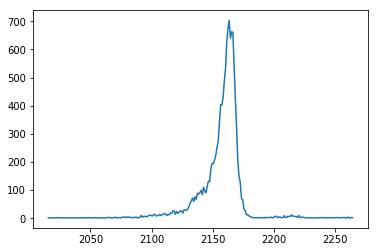

In [3]:
pl.subplot(111)
pl.plot(xvals,ymeas)
pl.show()

---

https://lmfit.github.io/lmfit-py/builtin_models.html#skewedgaussianmodel

In [4]:

def gauss_fn(p0, x):
    
    amp,mu,sigma1,sigma2,r,gamma = p0
    
    model1 = GaussianModel()
    model2 = GaussianModel()
    model3 = SkewedGaussianModel()
    
    
    # set initial parameter values
    params1 = model1.make_params(amplitude=amp * (1 - r/100), center=mu, sigma=sigma1)
    params2 = model2.make_params(amplitude=amp * (r/100), center=mu, sigma=sigma1)
    params3 = model3.make_params(amplitude=amp * (r/100), center=mu, sigma=sigma2, gamma=gamma)
    
    ygaus1 = model1.eval(params=params1,x=x)
    ygaus2 = model2.eval(params=params2,x=x)
    yskew = model3.eval(params=params3,x=x)
    
    yconv = np.convolve(ygaus2, yskew, mode='same')
    
    ymod = yconv + ygaus1
    
    return ymod

'''
def gf3(p0, x):
    #this is the fuctional form that we have been using in our manual fit
    #it is the sum of a gaussian and a skewed gaussian with the same mean
    #the extra parameters r and beta are introduced
    #r is the fraction of the height of the skewed gaussian given as a pecentage
    #beta is the 'skewneess' of the second skew gaussian
    #it is the decay constant of an exponential tail on the skewed gaussian
    #this exponential tail is convolved with a gaussian resolution function
    
    amp, mu, sigma, r, beta = p0
    
    #gaussian part
    ygaus = amp * (1 - r/100) * np.exp((-(x - mu)**2)/(2 * sigma**2))
    
    #'skew' gaussian part. erfc is 1 - the error function
    yskew = amp * (r/100) * np.exp((x-mu)/beta) * erfc( (x-mu)/(sigma * np.sqrt(2))  + sigma/(beta*np.sqrt(2)))
    #yskew = 0
    #ygaus = 0
    ymod = yskew + ygaus
    
    return ymod
'''

"\ndef gf3(p0, x):\n    #this is the fuctional form that we have been using in our manual fit\n    #it is the sum of a gaussian and a skewed gaussian with the same mean\n    #the extra parameters r and beta are introduced\n    #r is the fraction of the height of the skewed gaussian given as a pecentage\n    #beta is the 'skewneess' of the second skew gaussian\n    #it is the decay constant of an exponential tail on the skewed gaussian\n    #this exponential tail is convolved with a gaussian resolution function\n    \n    amp, mu, sigma, r, beta = p0\n    \n    #gaussian part\n    ygaus = amp * (1 - r/100) * np.exp((-(x - mu)**2)/(2 * sigma**2))\n    \n    #'skew' gaussian part. erfc is 1 - the error function\n    yskew = amp * (r/100) * np.exp((x-mu)/beta) * erfc( (x-mu)/(sigma * np.sqrt(2))  + sigma/(beta*np.sqrt(2)))\n    #yskew = 0\n    #ygaus = 0\n    ymod = yskew + ygaus\n    \n    return ymod\n"

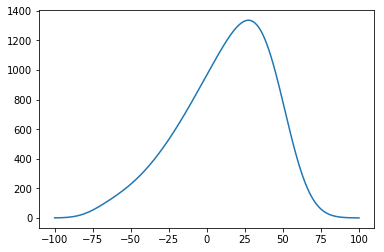

In [5]:
#test to see if this function looks correct
x = np.arange(-100, 100, step = 0.001)
y = gauss_fn([100, 25, 10, 50, 10,-5],x)

#y = np.exp(((x-5)/5)) * erfc(((x-5)/(10*2**0.5)) + 2/(5*2**0.5 ))
pl.plot(x,y)

pl.show()

In [6]:
def lnlike(p0, x, y):
    
    # get model for these parameters:
    #ymod = gauss_fn(p0,x)
    ymod = gauss_fn(p0,x)
    
    # Poisson loglikelihood:
    ll = np.sum(ymod[np.where(ymeas!=0)]*np.log(ymeas[np.where(ymeas!=0)])) - np.sum(ymeas) - np.sum(ymod[np.where(ymod!=0)]*np.log(ymod[np.where(ymod!=0)]) - ymod[np.where(ymod!=0)])
    
    return ll

In [7]:
# use maxvalue to guess amplitude:
a0 = np.max(ymeas)

# use position of maxvalue to guess mean:
m0 = xvals[np.argmax(ymeas)]

# just guess widths:
s10 = 10.
s20 = 50.

# just guess r and beta from what they usually turn out about from experience
r0 = 10.
b0 = -5.

# adjust the amplitude for the normalisation factor:
#a0*=s0*np.sqrt(2*np.pi)

print(a0,m0,s10,s20,r0,b0)
p0 = np.array([a0,m0,s10,s20,r0,b0])

704.0 2163.5 10.0 50.0 10.0 -5.0


In [8]:
bnds = ((None,None), (None,None), (0.1,None),(0.1,None),(0.1, 100), (0.1,None))

print(len(p0))
print(len(bnds))

6
6


In [9]:
nll = lambda *args: -lnlike(*args)

result = op.minimize(nll, p0, bounds=bnds, args=(xvals, ymeas))
p1 = result["x"]

In [10]:
print(p1)

[2414.62173827 2152.52307267    5.90147377    3.44168003    4.02132802
  483.25002624]


-1828.9195162267424


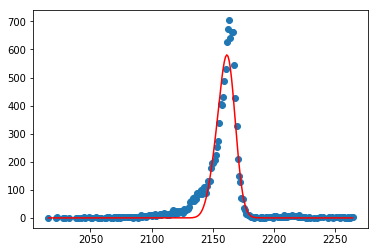

In [11]:
yfit = gauss_fn(p1,xvals)

fig = pl.figure(1)

ax = fig.add_subplot(111)

ax.scatter(xvals,ymeas)
ax.plot(xvals,yfit,c='r')

fig.savefig("gf3fit.png")

print(lnlike(p1, xvals, ymeas))

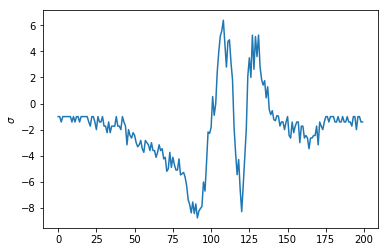

In [12]:
res = (yfit - ymeas)/np.sqrt(ymeas)
fig = pl.figure(1)
ax = fig.add_subplot(111)
pl.plot(res)
pl.ylabel(r"$\sigma$")
fig.savefig("residuals.png")

These residuals still look weird.

---

In [13]:
ndim, nwalkers = 6, 100
pos = [result["x"] + 1e-4*np.random.randn(ndim) for i in range(nwalkers)]

In [14]:
sampler = emcee.EnsembleSampler(nwalkers, ndim, lnlike, args=(xvals, ymeas))

In [19]:
p0 = sampler.run_mcmc(pos, 500) #this doesn't work with 500 as it tries to use a negative value of r

In [20]:
samples = sampler.chain[:, 50:, :].reshape((-1, ndim))
print(samples.shape)

(55000, 6)


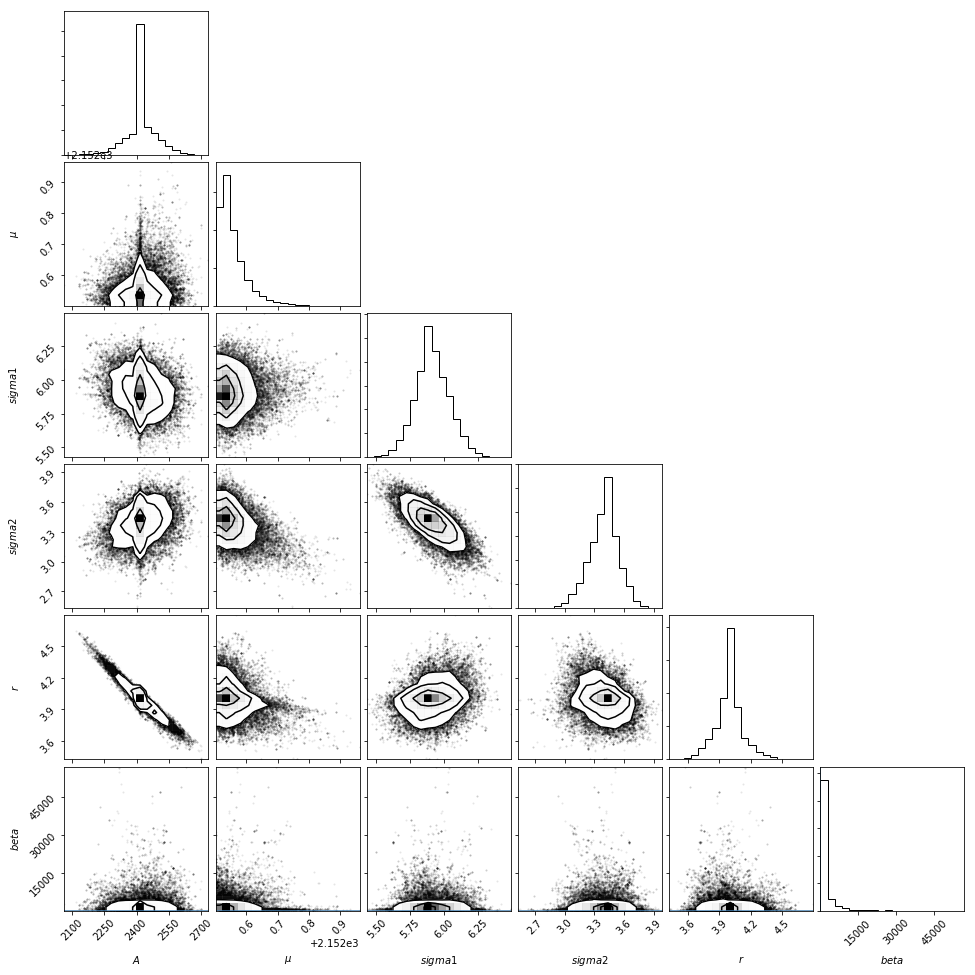

In [21]:
import corner

fig = corner.corner(samples, labels=["$A$", "$\mu$", "$sigma1$", "$sigma2$","$r$", "$beta$"],
                      truths=[a0, m0, s10,s20, r0, b0])
fig.savefig("triangle.png")